# Necessary Imports

In [2]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import os

np.random.seed(42) # to allow stable runs

# To plot the pictures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1. Separate the Features and label

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

# 2. Plots the first instance in the dataset

Saving figure some_digit_plot


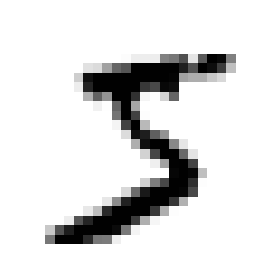

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [5]:
y[0] # The first instance in the label column is 5

'5'

# 3. Convert label into integer type

In [6]:
y = y.astype(np.uint8)
y.dtype

dtype('uint8')

# 4. Train/test split

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 5. Model Training

In [8]:
# For this binary classification, we only assume to results. Whether an instance will be five or not five
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train[y_train_5][:5]

array([5, 5, 5, 5, 5], dtype=uint8)

# 5.1 Binary Classification

## SGD Classifier

In [9]:
# We use SGD Classifier as our model. Stochastic Gradient Descent is great in handling large datasets
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
# Predicts the first instance as 5
sgd_clf.predict([X[0]]) 

array([ True])

### Cross validation

In [11]:
#Cross Validation Score (Accuracy)

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.95466667, 0.96975   , 0.9635    , 0.96533333, 0.94841667])

### --- Stratified KFold (Not ideal for classifiers)

In [12]:
# Stratified Kfold allows cross-validation with equal partitions of each class in the dataset

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# Call out the function

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
# For every iteration/fold, it creates a clone of the model, and fit the model to that train data fold. Then, we compute the accuracy
# by dividing the correct predictions with the total no. of predictions

0.9669
0.91625
0.96785


### --- Confusion Matrix 

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### --- Precision/Recall Score

In [15]:
from sklearn.metrics import precision_score, recall_score
print(f"Precision score: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall score: {recall_score(y_train_5, y_train_pred)}")

Precision score: 0.8370879772350012
Recall score: 0.6511713705958311


### --- Precision/Recall Tradeoff (Use when positive class is rare)

In [21]:
# We use decision function to get the score of the first intance in the train set using SGD Classifier model
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = (y_score > threshold)
y_some_digit_pred # Because the score of the instance is greater than the threshold, it was classified to be true (a 5)

array([ True])

In [24]:
threshold = 8000 # if we set a high threshold, then it will classify it as false
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
# In this case, we want to choose a threshold that will give us a 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [36]:
# If we set the threshold to this, we will be able to get a 90% precision
print(f"Threshold of 90% precision: {threshold_90_precision}")

Threshold of 90% precision: 3370.0194991439594


In [37]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
# We were able to achieve a precision score of 90%
print(f"Recall Score: {recall_score(y_train_5, y_train_pred_90)}")
print(f"Precision Score: {precision_score(y_train_5, y_train_pred_90)}")

Recall Score: 0.4799852425751706
Precision Score: 0.9000345901072293


### --- ROC Score (Use when positive class is not rare)

In [41]:
from sklearn.metrics import roc_auc_score

print(f"ROC AUC Score: {roc_auc_score(y_train_5, y_scores)}")

ROC AUC Score: 0.9604938554008616


### --- F1 Score

In [16]:
from sklearn.metrics import f1_score
print(f"F1 Score: {f1_score(y_train_5, y_train_pred)}")

F1 Score: 0.7325171197343846


## Random Forest Classifier

In [57]:
# Instead of a decision function that returns scores, RandomForest uses the predict_proba function
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")
forest_clf.fit(X_train, y_train_5)
y_forest_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
y_forest_pred[:5]

array([ True, False, False, False, False])

### --- Precision/Recall

In [58]:
from sklearn.metrics import precision_score, recall_score
print(f"Precision score: {precision_score(y_train_5, y_forest_pred)}")
print(f"Recall score: {recall_score(y_train_5, y_forest_pred)}")

Precision score: 0.9905083315756169
Recall score: 0.8662608374838591


### --- ROC Score

In [59]:
# ROC AUC requires scores. RandomForest outputs probabilities so we need to convert it into scores. One way to do this is to use the proba of positive instances as scores 
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest = y_probas_forest[:, 1]
print(f"ROC AUC Score: {roc_auc_score(y_train_5, y_scores_forest)}")

ROC AUC Score: 0.9983436731328145


### --- F1 Score

In [60]:
from sklearn.metrics import f1_score
print(f"F1 Score: {f1_score(y_train_5, y_forest_pred)}")

F1 Score: 0.9242275142688446


# 5.2 Multiclass Classification

## SGD Classifier (OVA)

In [62]:
# SGD Classifier automatically runs OVA
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([3], dtype=uint8)

In [63]:
sgd_clf.decision_function([some_digit]) # Returns the scores of falling to each class (0-9)

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

# SGD Classifier (OVO)

In [64]:
# SGD Classifier automatically runs OVA so in this case, we forced it to do OVO
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([X[0]])

array([5], dtype=uint8)

In [65]:
ovo_clf.decision_function([some_digit])

array([[2.66666696, 3.66666714, 5.33333258, 8.33333319, 0.6666669 ,
        9.33333315, 0.66666684, 2.66666841, 5.33333214, 6.33333275]])

# Random Forest (no need to OVO and OVA)

In [66]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([X[0]])

array([5], dtype=uint8)

In [67]:
forest_clf.predict_proba([X[0]])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

# K Nearest Neighbors

In [72]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

knn_y_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
knn_y_pred[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [75]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.9709 , 0.9698 , 0.97035])